<a href="https://colab.research.google.com/github/RajeswariKumaran/SSLMethodsAnalysis/blob/main/transfer_learning_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# transfer learning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter


In [ ]:
#Load Pretrained ResNet18 and Modify Output
def get_resnet18_for_cifar10():
    model = resnet18(weights='IMAGENET1K_V1')  # Pretrained on ImageNet
    model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
    return model


In [ ]:
# 3. Train Function (Supervised Only)
def train_supervised(model, train_loader, test_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss:.4f} - Train Acc: {acc:.2f}%")

    evaluate(model, test_loader, device)


In [ ]:
#  4. Evaluation with Metrics + Confusion Matrix
def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    print("\n✅ Test Accuracy: {:.2f}%".format(100 * np.mean(y_pred == y_true)))
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ],
                yticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# === 1. DATASET SETUP (CIFAR-10) ===

def get_cifar10_dataloaders(num_labeled=10000, batch_size=64):
    # transform = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.5,), (0.5,))
    # ])
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)

    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

    full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Randomly split labeled/unlabeled
    indices = np.arange(len(full_trainset))
    np.random.shuffle(indices)
    labeled_indices = indices[:num_labeled]
    unlabeled_indices = indices[num_labeled:]

    labeled_set = Subset(full_trainset, labeled_indices)
    unlabeled_set = Subset(full_trainset, unlabeled_indices)

    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, test_loader

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


Epoch [1/20] - Loss: 257.2728 - Train Acc: 41.81%
Epoch [2/20] - Loss: 174.6024 - Train Acc: 60.88%
Epoch [3/20] - Loss: 144.5046 - Train Acc: 67.71%
Epoch [4/20] - Loss: 129.0770 - Train Acc: 71.34%
Epoch [5/20] - Loss: 117.4572 - Train Acc: 73.72%
Epoch [6/20] - Loss: 105.4811 - Train Acc: 76.30%
Epoch [7/20] - Loss: 97.2739 - Train Acc: 78.12%
Epoch [8/20] - Loss: 90.0584 - Train Acc: 80.03%
Epoch [9/20] - Loss: 82.1849 - Train Acc: 81.71%
Epoch [10/20] - Loss: 77.9275 - Train Acc: 82.65%
Epoch [11/20] - Loss: 72.0965 - Train Acc: 83.68%
Epoch [12/20] - Loss: 66.2298 - Train Acc: 85.23%
Epoch [13/20] - Loss: 63.7786 - Train Acc: 85.60%
Epoch [14/20] - Loss: 60.5430 - Train Acc: 86.45%
Epoch [15/20] - Loss: 52.5674 - Train Acc: 88.24%
Epoch [16/20] - Loss: 54.0978 - Train Acc: 88.11%
Epoch [17/20] - Loss: 48.6458 - Train Acc: 89.19%
Epoch [18/20] - Loss: 44.9878 - Train Acc: 89.94%
Epoch [19/20] - Loss: 39.2662 - Train Acc: 91.09%
Epoch [20/20] - Loss: 41.3145 - Train Acc: 91.07%

✅ 

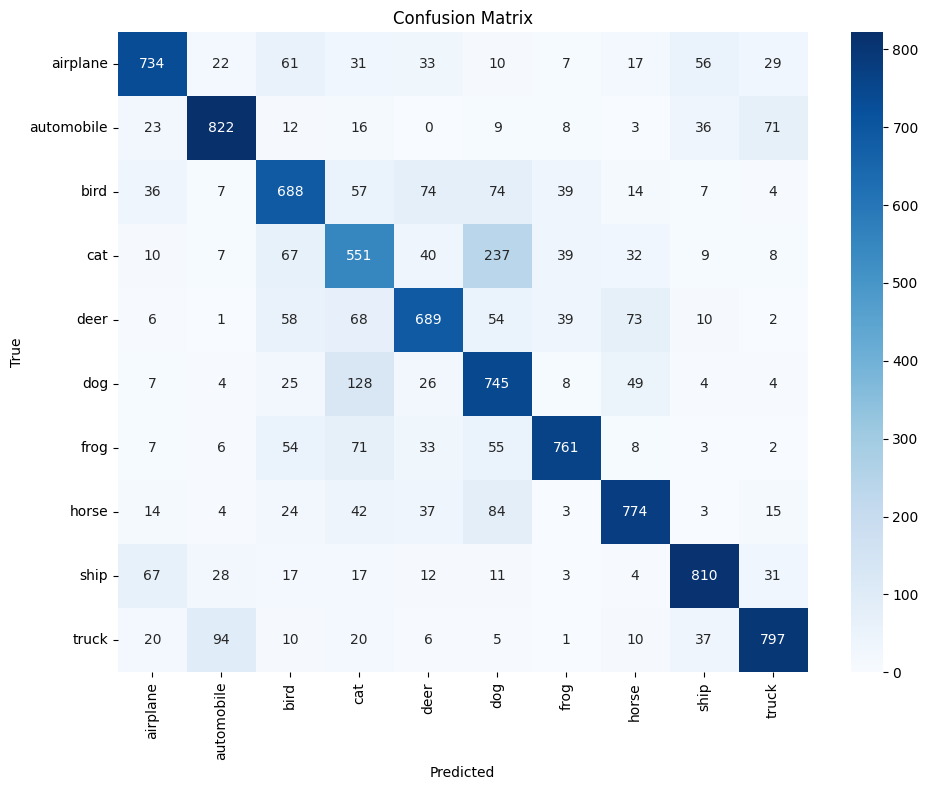

In [ ]:
# 5. Run the Training (Reusing Your Loaders)
# assuming you have already called
labeled_loader, unlabeled_loader, test_loader = get_cifar10_dataloaders()
# then run
model = get_resnet18_for_cifar10()
train_supervised(model, labeled_loader, test_loader, epochs=20, lr=1e-4)



In [ ]:
# Baselined supervised

In [ ]:
# 1. Model: SimpleCNN (from your VAT code)
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# 2. CIFAR-10 Dataset & Data Loaders
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np

def get_cifar10_dataloaders(batch_size=128, num_labeled=4000):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    indices = np.arange(len(full_train))
    np.random.shuffle(indices)

    labeled_indices = indices[:num_labeled]
    unlabeled_indices = indices[num_labeled:]

    labeled_set = Subset(full_train, labeled_indices)
    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return labeled_loader, test_loader


In [ ]:
#  3. Train Function (Supervised Only)
def train_supervised(model, train_loader, test_loader, epochs=30, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss:.4f} - Train Acc: {acc:.2f}%")

    evaluate(model, test_loader, device)


In [ ]:
# 4. Evaluation Function with Metrics & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    acc = 100 * np.mean(y_pred == y_true)
    print(f"\n✅ Test Accuracy: {acc:.2f}%")
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ],
                yticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Epoch [1/30] - Loss: 67.6736 - Train Acc: 21.43%
Epoch [2/30] - Loss: 60.1067 - Train Acc: 31.40%
Epoch [3/30] - Loss: 56.3643 - Train Acc: 35.50%
Epoch [4/30] - Loss: 52.4416 - Train Acc: 40.38%
Epoch [5/30] - Loss: 51.9760 - Train Acc: 40.35%
Epoch [6/30] - Loss: 49.5059 - Train Acc: 41.90%
Epoch [7/30] - Loss: 46.7003 - Train Acc: 46.45%
Epoch [8/30] - Loss: 45.6878 - Train Acc: 45.98%
Epoch [9/30] - Loss: 44.6064 - Train Acc: 48.60%
Epoch [10/30] - Loss: 43.0180 - Train Acc: 51.35%
Epoch [11/30] - Loss: 41.6953 - Train Acc: 53.17%
Epoch [12/30] - Loss: 40.9253 - Train Acc: 52.75%
Epoch [13/30] - Loss: 39.2967 - Train Acc: 55.52%
Epoch [14/30] - Loss: 38.3067 - Train Acc: 56.67%
Epoch [15/30] - Loss: 37.2082 - Train Acc: 57.90%
Epoch [16/30] - Loss: 36.4215 - Train Acc: 58.98%
Epoch [17/30] - Loss: 34.5285 - Train Acc: 60.60%
Epoch [18/30] - Loss: 34.3250 - Train Acc: 62.30%
Epoch [19/30] - Loss: 33.2095 - Train Acc: 62.10%
Epoch [20/30] - Loss: 33.2203 - Train Acc: 61.88%
Epoch [21

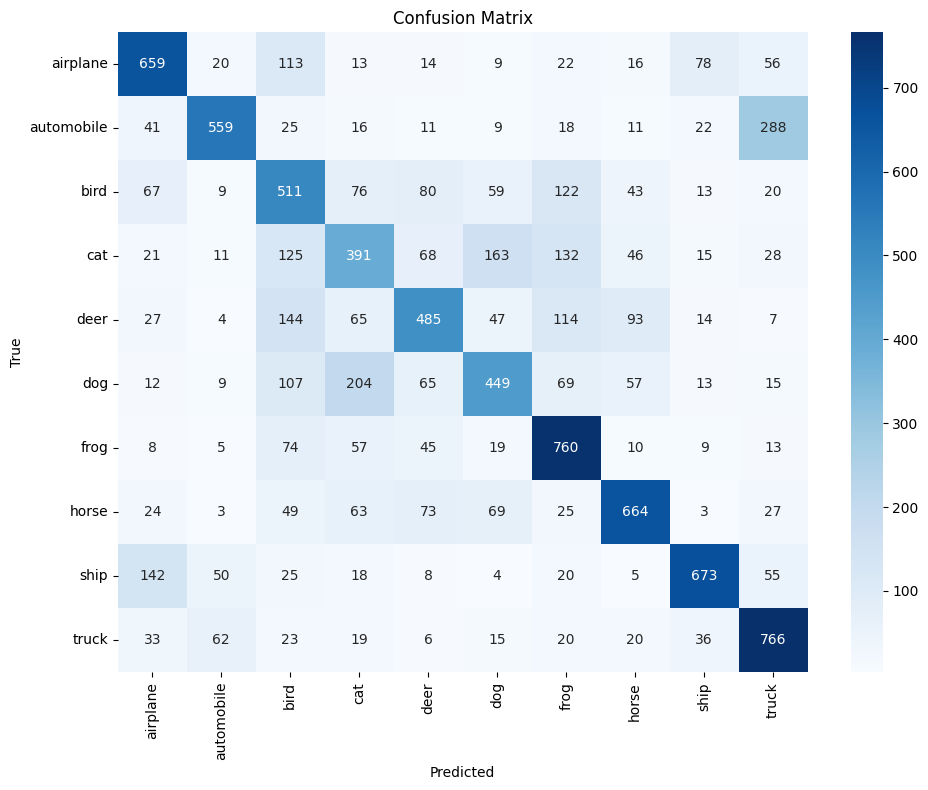

In [ ]:
# 5. Run the Whole Pipeline
# Prepare data
labeled_loader, test_loader = get_cifar10_dataloaders()

# Build model
model = SimpleCNN()

# Train supervised
train_supervised(model, labeled_loader, test_loader, epochs=30)


In [ ]:
# # Mean teacher
# PyTorch implementation of the Mean Teacher semi-supervised method for CIFAR-10, using your existing labeled/unlabeled splits and SimpleCNN backbone. The core idea:

# Student network trains on both supervised and unsupervised (consistency) loss.
# Teacher network has the same architecture; weights are an EMA of the student.
# Unlabeled images get two augmentations: student and teacher see differently augmented versions.
# You minimize cross‑entropy on labeled data plus consistency loss (MSE between student + teacher softmax outputs) on unlabeled data.

In [ ]:
# Authoritative Reference
# Mean Teacher has shown strong results, e.g. 6.3% test error on CIFAR-10 with 4,000 labels using a ResNet-26 student model
# https://github.com/CuriousAI/mean-teacher?utm_source=chatgpt.com
# https://arxiv.org/abs/2004.09665?utm_source=chatgpt.com

In [ ]:
# Code Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

# Assume SimpleCNN is defined as before

def update_ema(student, teacher, ema_decay):
    for s_param, t_param in zip(student.parameters(), teacher.parameters()):
        t_param.data = ema_decay * t_param.data + (1 - ema_decay) * s_param.data

def consistency_loss(log_s, log_t):
    # MSE loss between softmax probabilities
    p_s = F.softmax(log_s, dim=1)
    p_t = F.softmax(log_t, dim=1).detach()
    return F.mse_loss(p_s, p_t)


In [ ]:
# Training Loop
def train_mean_teacher(student, teacher, labeled_loader, unlabeled_loader, test_loader,
                       epochs=50, lr=1e-3, ema_decay=0.99, lambda_u=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    student, teacher = student.to(device), teacher.to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=lr)
    ce_loss = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        student.train()
        teacher.train()
        total_sup, total_unsup = 0.0, 0.0

        unl_iter = iter(unlabeled_loader)
        for (x_l, y_l) in labeled_loader:
            try:
                # Get paired augmentations and the dummy label from the unlabeled loader
                (x_u1, x_u2), _ = next(unl_iter)
            except StopIteration:
                unl_iter = iter(unlabeled_loader) # Reset unlabeled loader if it runs out
                (x_u1, x_u2), _ = next(unl_iter)


            x_l, y_l = x_l.to(device), y_l.to(device)
            x_u1, x_u2 = x_u1.to(device), x_u2.to(device)

            optimizer.zero_grad()

            out_l = student(x_l)
            loss_sup = ce_loss(out_l, y_l)

            out_u_s = student(x_u1)
            with torch.no_grad():
                out_u_t = teacher(x_u2)
            loss_cons = consistency_loss(out_u_s, out_u_t)

            loss = loss_sup + lambda_u * loss_cons
            loss.backward()
            optimizer.step()

            update_ema(student, teacher, ema_decay)

            total_sup += loss_sup.item()
            total_unsup += loss_cons.item()

        print(f"[Epoch {epoch}] Sup_loss: {total_sup/len(labeled_loader):.4f} | Unsup_loss: {total_unsup/len(labeled_loader):.4f}")
        # Evaluate using the teacher model as is common practice in Mean Teacher
        evaluate(teacher, test_loader, device)

In [ ]:
# Dataset Loaders with Labeled and Unlabeled Splits
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np

class CIFAR10Pair(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x1 = self.transform(x)
            x2 = self.transform(x)
        return (x1, x2), y # Return a tuple of (paired_images, label)

    def __len__(self):
        return len(self.subset)


def get_cifar10_ssl_loaders(num_labeled=4000, batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    indices = np.arange(len(full_train))
    np.random.shuffle(indices)
    labeled_idx = indices[:num_labeled]
    unlabeled_idx = indices[num_labeled:]

    labeled_set = Subset(full_train, labeled_idx)
    unlabeled_set = Subset(full_train, unlabeled_idx)

    # Wrap the unlabeled subset with the custom dataset for paired augmentations
    unlabeled_paired_set = CIFAR10Pair(unlabeled_set, transform=transform_train)


    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True, num_workers=2)
    unlabeled_loader = DataLoader(unlabeled_paired_set, batch_size=batch_size, shuffle=True, num_workers=2) # Shuffle unlabeled loader
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return labeled_loader, unlabeled_loader, test_loader, unlabeled_set

In [ ]:
# Setup: SimpleCNN (as used earlier)
import torch
import torch.nn as nn
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Usage
# Prepare data
labeled_loader, unlabeled_loader, test_loader, unlabeled_set = get_cifar10_ssl_loaders()  # ensure unlabeled loader yields paired augmentations

# Models
student = SimpleCNN()
teacher = copy.deepcopy(student)
for p in teacher.parameters():
    p.requires_grad = False

# Train
train_mean_teacher(student, teacher, labeled_loader, unlabeled_loader, test_loader,
                   epochs=30, lr=3e-4, ema_decay=0.995, lambda_u=0.5)


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipython-input-16-412656581.py", line 14, in __getitem__
    x1 = self.transform(x)
         ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torchvision/transforms/transforms.py", line 137, in __call__
    return F.to_tensor(pic)
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py", line 142, in to_tensor
    raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


In [ ]:
epochs=50
lr=1e-3
ema_decay=0.99
lambda_u=1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student, teacher = student.to(device), teacher.to(device)
optimizer = torch.optim.Adam(student.parameters(), lr=lr)

In [ ]:
for x,y in unlabeled_loader.dataset.subset:
  print(x, y)
  break

tensor([[[-2.4291,  2.4947,  2.4753,  ..., -0.4906, -1.0915, -1.3435],
         [-2.4291,  2.4753,  2.4753,  ..., -0.9170, -1.8863, -2.0608],
         [-2.4291,  2.5141,  2.4947,  ..., -1.2466, -2.0414, -2.1383],
         ...,
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],

        [[-2.4183,  2.5771,  2.5575,  ..., -0.5696, -1.1006, -1.3169],
         [-2.4183,  2.5575,  2.5771,  ..., -0.9629, -1.9659, -2.1233],
         [-2.4183,  2.5968,  2.5771,  ..., -1.3169, -2.0446, -2.1233],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],

        [[-2.2214,  2.7342,  2.6562,  ..., -0.5435, -1.0118, -1.2069],
         [-2.2214,  2.6952,  2.7342,  ..., -0

In [ ]:
ce_loss = nn.CrossEntropyLoss()

for epoch in range(1, epochs + 1):
    student.train()
    teacher.train()
    total_sup, total_unsup = 0.0, 0.0

    unl_iter = iter(unlabeled_loader.dataset.subset)
    for (x_l, y_l) in labeled_loader:
        try:
            # print(x_l)
            # i = 1
            # for x, y in unlabeled_loader.dataset.subset:
            #     print(x, y)
            #     if (i==1):
            #       x_u1 = x
            #     elif (i==3):
            #       x_u2 = x
            #     if (i==3): break
            #     i=i+1
            # Get paired augmentations and the dummy label from the unlabeled loader
            (x_u1, _), (x_u2, _) = next(unl_iter)
        except StopIteration:
            break

        x_l, y_l = x_l.to(device), y_l.to(device)
        x_u1.to(device)
        # x_u2.to(device)
        print(type(x_u2))
        x_u1, x_u2 = x_u1.to(device), x_u2.to(device)

        optimizer.zero_grad()

        out_l = student(x_l)
        loss_sup = ce_loss(out_l, y_l)

        out_u_s = student(x_u1)
        with torch.no_grad():
            out_u_t = teacher(x_u2)
        loss_cons = consistency_loss(out_u_s, out_u_t)

        loss = loss_sup + lambda_u * loss_cons
        loss.backward()
        optimizer.step()

        update_ema(student, teacher, ema_decay)

        total_sup += loss_sup.item()
        total_unsup += loss_cons.item()

    print(f"[Epoch {epoch}] Sup_loss: {total_sup/len(labeled_loader):.4f} | Unsup_loss: {total_unsup/len(labeled_loader):.4f}")


Streaming output truncated to the last 5000 lines.
         [-1.1723e-01, -5.8924e-01, -1.1989e+00,  ..., -1.2579e+00,
          -1.3759e+00, -1.3562e+00],
         [-4.7124e-01, -9.4324e-01, -1.0809e+00,  ..., -1.5332e+00,
          -1.5136e+00, -1.3759e+00]],

        [[-1.5971e+00, -1.4020e+00, -6.4106e-01,  ..., -1.9678e+00,
          -1.8702e+00, -1.8507e+00],
         [-1.5190e+00, -1.2069e+00, -4.2645e-01,  ..., -1.8702e+00,
          -1.8702e+00, -1.8312e+00],
         [-1.3825e+00, -1.0508e+00, -7.1910e-01,  ..., -1.6946e+00,
          -1.8897e+00, -1.8507e+00],
         ...,
         [-1.6361e+00, -1.5580e+00, -1.2654e+00,  ..., -1.1093e+00,
          -1.1678e+00, -1.2264e+00],
         [-1.5385e+00, -1.6556e+00, -1.4800e+00,  ..., -1.2069e+00,
          -1.2459e+00, -1.2264e+00],
         [-1.6166e+00, -1.6556e+00, -1.1873e+00,  ..., -1.4410e+00,
          -1.3629e+00, -1.2264e+00]]]) 5
<class 'torch.Tensor'>
tensor([[[-0.3161,  0.2461,  0.1104,  ..., -2.4291, -2.4291, -2.42

In [ ]:
# ⚠️ Important Implementation Details

# Paired augmentations: Ensure unlabeled_loader yields two differently augmented copies per sample.
# EMA updates: EMA decay (e.g. 0.99–0.999) controls how quickly the teacher catches up.
# You evaluate the student model; optionally track teacher as well.
# Hyperparameters can be tuned (lambda_u, decay, lr).

In [ ]:
# pseudo labelling
# What is Pseudo-Labeling?

# Pseudo-labeling is a simple semi-supervised learning approach:

# Train a model on the labeled data.
# Use that model to predict labels on the unlabeled data.
# Treat high-confidence predictions as "pseudo-labels".
# Retrain (or continue training) the model using both labeled and pseudo-labeled data.

In [ ]:
# Setup: SimpleCNN (as used earlier)
import torch
import torch.nn as nn
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Dataset Loaders with Labeled and Unlabeled Splits
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

def get_cifar10_ssl_loaders(num_labeled=4000, batch_size=128):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    indices = np.arange(len(full_train))
    np.random.shuffle(indices)
    labeled_idx = indices[:num_labeled]
    unlabeled_idx = indices[num_labeled:]

    labeled_set = Subset(full_train, labeled_idx)
    unlabeled_set = Subset(full_train, unlabeled_idx)

    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True, num_workers=2)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return labeled_loader, unlabeled_loader, test_loader, unlabeled_set


In [ ]:
# Step 1: Train on Labeled Data
def train_supervised(model, loader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total, correct = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Train Accuracy: {acc:.2f}%")


In [ ]:
pseudo_data

NameError: name 'pseudo_data' is not defined

In [ ]:
loader = combined_loader
epochs=20
lr=1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):
    model.train()
    total, correct = 0, 0
    for x, y in combined_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} - Train Accuracy: {acc:.2f}%")

AttributeError: Caught AttributeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 211, in collate
    return [
           ^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 269, in collate_tensor_fn
    numel = sum(x.numel() for x in batch)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 269, in <genexpr>
    numel = sum(x.numel() for x in batch)
                ^^^^^^^
AttributeError: 'int' object has no attribute 'numel'


In [ ]:
print(type(pseudo_data[0]))  # Should be tuple
print(type(pseudo_data[0][0]))  # Should be torch.Tensor (image)
print(type(pseudo_data[0][1]))  # Should be int or torch scalar


<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>



✅ Final Test Accuracy: 10.72%
              precision    recall  f1-score   support

           0       0.16      0.17      0.17      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.10      0.90      0.18      1000
           4       0.00      0.00      0.00      1000
           5       0.09      0.01      0.02      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.11     10000
   macro avg       0.04      0.11      0.04     10000
weighted avg       0.04      0.11      0.04     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


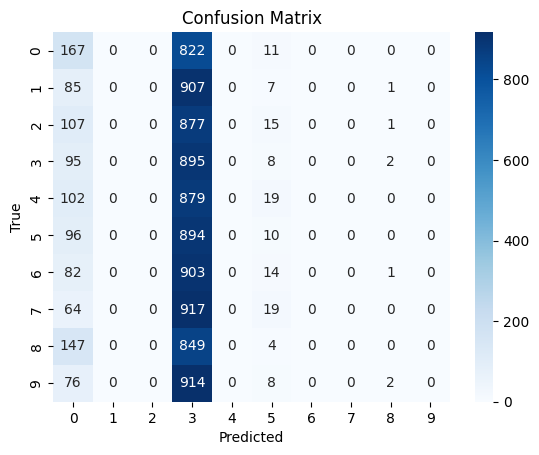

In [ ]:
evaluate(model, test_loader)

In [ ]:
# Step 2: Generate Pseudo Labels
def generate_pseudo_labels(model, unlabeled_set, threshold=0.95):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    pseudo_data = []

    with torch.no_grad():
        for i in range(len(unlabeled_set)):
            x, _ = unlabeled_set[i]
            x = x.unsqueeze(0).to(device)
            out = model(x)
            probs = F.softmax(out, dim=1)
            conf, pred = probs.max(1)
            if conf.item() >= threshold:
                pseudo_data.append((x.cpu().squeeze(), pred.item()))

    print(f"Generated {len(pseudo_data)} pseudo-labels (threshold={threshold})")
    return pseudo_data


In [ ]:
# Step 3: Create Pseudo-Labeled Dataset & Combine
from torch.utils.data import TensorDataset, ConcatDataset

def create_combined_dataset(labeled_loader, pseudo_data):
    # Extract labeled set
    labeled_dataset = labeled_loader.dataset

    if len(pseudo_data) == 0:
        return labeled_loader

    images, labels = zip(*pseudo_data)
    pseudo_dataset = TensorDataset(torch.stack(images), torch.tensor(labels))

    combined_dataset = ConcatDataset([labeled_dataset, pseudo_dataset])
    combined_loader = DataLoader(combined_dataset, batch_size=128, shuffle=True, num_workers=2)
    return combined_loader


In [ ]:
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import torch

def create_combined_dataset(labeled_loader, pseudo_data):
    labeled_dataset = labeled_loader.dataset

    if len(pseudo_data) == 0:
        return labeled_loader

    images, labels = zip(*pseudo_data)
    images = torch.stack(images)  # Ensure all images have the same shape
    labels = torch.tensor(labels, dtype=torch.long)

    pseudo_dataset = TensorDataset(images, labels)

    combined_dataset = ConcatDataset([labeled_dataset, pseudo_dataset])
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=2
    )

    return combined_loader


In [ ]:
class ToTensorLabelWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.long)
        return x, y

    def __len__(self):
        return len(self.dataset)

In [ ]:
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import torch

def create_combined_dataset(labeled_loader, pseudo_data):
    # labeled_dataset = labeled_loader.dataset
    labeled_dataset = ToTensorLabelWrapper(labeled_loader.dataset)

    if len(pseudo_data) == 0:
        return labeled_loader

    # Unzip pseudo_data and convert to tensors
    images, labels = zip(*pseudo_data)

    # Convert images to a single 4D tensor: [N, C, H, W]
    images = torch.stack(images)

    # Convert labels to a 1D tensor: [N]
    labels = torch.tensor(labels, dtype=torch.long)

    # Create pseudo dataset
    pseudo_dataset = TensorDataset(images, labels)


    # Combine datasets
    combined_dataset = ConcatDataset([labeled_dataset, pseudo_dataset])

    # Create new DataLoader
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=2
    )

    return combined_loader


In [ ]:
images, labels = zip(*pseudo_data)

# Convert images to a single 4D tensor: [N, C, H, W]
images = torch.stack(images)

# Convert labels to a 1D tensor: [N]
labels = torch.tensor(labels, dtype=torch.long)

# Create pseudo dataset
pseudo_dataset = TensorDataset(images, labels)

In [ ]:
combined_dataset = ConcatDataset([labeled_dataset, pseudo_dataset])

In [ ]:
labeled_dataset = ToTensorLabelWrapper(labeled_loader.dataset)

In [ ]:
for i in range(len(labeled_dataset)):
    x, y = labeled_dataset[i]
    print(f"Index {i}: type(x)={type(x)}, type(y)={type(y)}")

NameError: name 'labeled_dataset' is not defined

In [ ]:
labeled_dataset = labeled_loader.dataset
type(labeled_dataset)

torch.utils.data.dataset.Subset

In [ ]:
# labeled_loader, unlabeled_loader, test_loader, unlabeled_set = get_cifar10_ssl_loaders()
# model = SimpleCNN()
pseudo_data = generate_pseudo_labels(model, unlabeled_set, threshold=0.95)
# combined_loader = create_combined_dataset(labeled_loader, pseudo_data)

# for x, y in combined_loader:
#     print(x, y)
#     break


Generated 4616 pseudo-labels (threshold=0.95)


In [ ]:
# Step 4: Retrain with Pseudo-Labels
def retrain_with_pseudo_labels(model, combined_loader, test_loader, epochs=20, lr=1e-3):
    train_supervised(model, combined_loader, epochs, lr)
    evaluate(model, test_loader)


In [ ]:
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\n✅ Final Test Accuracy: {acc:.2f}%")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
# Run Full Pseudo-Labeling Pipeline
# Load data
# labeled_loader, unlabeled_loader, test_loader, unlabeled_set = get_cifar10_ssl_loaders()

# Step 1: Train on labeled data
# model = SimpleCNN()
# train_supervised(model, labeled_loader)

# Step 2: Generate pseudo-labels
pseudo_data = generate_pseudo_labels(model, unlabeled_set, threshold=0.95)

# Step 3: Combine datasets
# combined_loader = create_combined_dataset(labeled_loader, pseudo_data)

# Step 4: Retrain model
#retrain_with_pseudo_labels(model, combined_loader, test_loader)


Generated 4544 pseudo-labels (threshold=0.95)


TypeError: 'DataLoader' object is not subscriptable

In [ ]:
combined_loader = create_combined_dataset(labeled_loader, pseudo_data)

Epoch 1/20 - Train Accuracy: 91.61%
Epoch 2/20 - Train Accuracy: 91.25%
Epoch 3/20 - Train Accuracy: 91.84%
Epoch 4/20 - Train Accuracy: 91.90%
Epoch 5/20 - Train Accuracy: 92.08%
Epoch 6/20 - Train Accuracy: 92.66%
Epoch 7/20 - Train Accuracy: 92.90%
Epoch 8/20 - Train Accuracy: 93.69%
Epoch 9/20 - Train Accuracy: 93.28%
Epoch 10/20 - Train Accuracy: 93.61%
Epoch 11/20 - Train Accuracy: 93.57%
Epoch 12/20 - Train Accuracy: 93.84%
Epoch 13/20 - Train Accuracy: 94.16%
Epoch 14/20 - Train Accuracy: 93.68%
Epoch 15/20 - Train Accuracy: 94.34%
Epoch 16/20 - Train Accuracy: 94.52%
Epoch 17/20 - Train Accuracy: 94.55%
Epoch 18/20 - Train Accuracy: 94.80%
Epoch 19/20 - Train Accuracy: 94.93%
Epoch 20/20 - Train Accuracy: 94.98%

✅ Final Test Accuracy: 63.05%
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1000
           1       0.77      0.72      0.75      1000
           2       0.52      0.51      0.51      1000
           3       0.

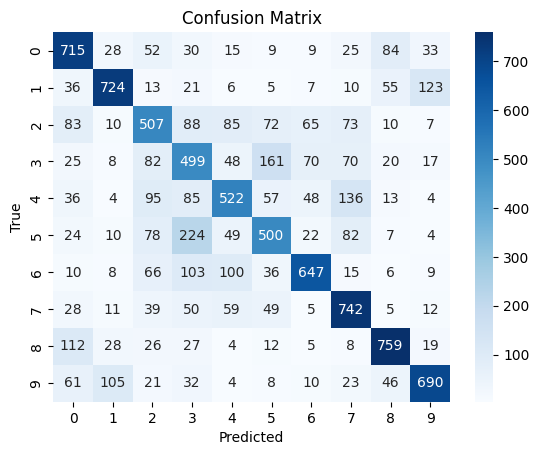

In [ ]:
# Step 4: Retrain model
retrain_with_pseudo_labels(model, combined_loader, test_loader)

In [ ]:
# Step 4: Retrain model
retrain_with_pseudo_labels(model, combined_loader.dataset, test_loader)

AttributeError: 'int' object has no attribute 'to'

In [ ]:
print(type(combined_loader))
print(type(pseudo_data))
print(type(labeled_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'list'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
pseudo_data[0]

(tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          ...,
          [-2.4291, -2.4291,  0.9245,  ...,  0.4205,  0.7307,  0.6338],
          [-2.4291, -2.4291,  0.4205,  ...,  0.9245,  0.7888,  0.5950],
          [-2.4291, -2.4291, -0.0447,  ...,  0.9439,  0.8276,  0.5562]],
 
         [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          ...,
          [-2.4183, -2.4183,  0.7481,  ...,  0.1778,  0.4531,  0.2761],
          [-2.4183, -2.4183,  0.2564,  ...,  0.6301,  0.4924,  0.3154],
          [-2.4183, -2.4183, -0.1566,  ...,  0.6104,  0.5121,  0.2958]],
 
         [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
          [-2.2214, -2.2214,

In [ ]:
combined_loader[0][0]

TypeError: 'DataLoader' object is not subscriptable

In [ ]:
def my_collate(batch):
    """Define collate_fn myself because the default_collate_fn throws errors like crazy"""
    # item: a tuple of (img, label)
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    data = torch.stack(data)
    target = torch.LongTensor(target)
    return [data, target]

In [ ]:
my_collate(combined_loader)

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 269, in collate_tensor_fn
    numel = sum(x.numel() for x in batch)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 269, in <genexpr>
    numel = sum(x.numel() for x in batch)
                ^^^^^^^
AttributeError: 'int' object has no attribute 'numel'


In [ ]:
for x, y in labeled_loader.dataset.dataset:
  print("x")
  print(x)
  print("y")
  print(y)

Streaming output truncated to the last 5000 lines.
         [-1.5761, -1.6924, -1.6924,  ..., -1.2078, -1.1884, -1.1690],
         [-1.6149, -1.6149, -1.6731,  ..., -0.6263, -0.5875, -0.4712],
         ...,
         [-1.2660, -1.2078, -1.1884,  ..., -0.8007, -0.9170, -1.0140],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],

        [[-1.1792, -1.2579, -1.2579,  ..., -0.6876, -0.7662, -0.7859],
         [-1.0022, -1.1202, -1.1399,  ..., -0.6089, -0.5696, -0.5499],
         [-1.0416, -1.0416, -1.1006,  ...,  0.0204,  0.0794,  0.2171],
         ...,
         [-0.6286, -0.5696, -0.5499,  ..., -0.0976, -0.2352, -0.3139],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],

        [[-1.2264, -1.3239, -1.3044,  ..., -0.9922, -1.0508, -1.0898],
         [-1.1483, -1.2849, -1.2849,  ..., -1.0898, -1.0508, -1.0

In [ ]:
#  Tips

# Tune the threshold (0.9–0.95 works well).
# You can repeat the pseudo-labeling loop multiple times for better performance.
# Works best when the model is decently trained on labeled data before generating pseudo-labels.